## [MLflow Integration via OpenTelemetry](https://langfuse.com/guides/cookbook/otel_integration_mlflow)

Langfuse is an OpenTelemetry backend, allowing trace ingestion from various OpenTelemetry instrumentation libraries. This guide demonstrates how to use the MLflow instrumentation library to instrument a compatible framework or LLM provider.

### Step 1: Install Dependencies

In [1]:
# %pip install mlflow openai opentelemetry-exporter-otlp-proto-http "langfuse<3.0.0"

%pip install mlflow openai opentelemetry-exporter-otlp-proto-http

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/26.4 MB ? eta -:--:--
     ---------------------------------------- 0.3/26.4 MB ? eta -:--:--
     -- ------------------------------------- 1.6/26.4 MB 5.2 MB/s eta 0:00:05
     ----- ---------------------------------- 3.4/26.4 MB 6.3 MB/s eta 0:00:04
     ----- ---------------------------------- 3.9/26.4 MB 6.3 MB/s eta 0:00:04
     ------- -------------------------------- 5.2/26.4 MB 5.5 MB/s eta 0:00:04
     ---------- ----------------------------- 6.8/26.4 MB 6.4 MB/s eta 0:00:04
     ----------- ---------------------------- 7.6/26.4 MB 5.7 MB/s eta 0:00:04
     -------------- ------------------------- 9.7/26.4 MB 6.3 MB/s eta 0:00:03
     --------------- ------------------------ 10.0/26.4 MB 6.3 MB/s eta 0:00:03
     ----------------- ---------------------- 11.3/26.4 MB 5.7 MB/s eta 0:00:03
     ------------------- -------------------- 12.8/26.4 MB 5.9 MB/s eta 0:00:03
  

### Step 2: Configure Environment Variables

In [2]:
import os
import base64


# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

# Build Basic Auth header.
LANGFUSE_AUTH = base64.b64encode(
    f"{os.environ.get('LANGFUSE_PUBLIC_KEY')}:{os.environ.get('LANGFUSE_SECRET_KEY')}".encode()
).decode()

# Configure OpenTelemetry endpoint & headers
os.environ["OTEL_EXPORTER_OTLP_TRACES_ENDPOINT"] = (
    os.environ.get("LANGFUSE_HOST") + "/api/public/otel/v1/traces"
)
os.environ["OTEL_EXPORTER_OTLP_TRACES_HEADERS"] = f"Authorization=Basic {LANGFUSE_AUTH}"
os.environ['OTEL_EXPORTER_OTLP_TRACES_PROTOCOL']= "http/protobuf"

# Your openai key
# os.environ["OPEN_AI_URL"] = "https://open.bigmodel.cn/api/paas/v4/"
os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

Configure tracer_provider and add a span processor to export traces to Langfuse. OTLPSpanExporter() uses the endpoint and headers from the environment variables.

In [3]:
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace.export import SimpleSpanProcessor


trace_provider = TracerProvider()
trace_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter()))

from opentelemetry import trace
trace.set_tracer_provider(trace_provider)

# Creates a tracer from the global tracer provider
tracer = trace.get_tracer(__name__)

### Step 3: Initialize Instrumentation

In [4]:
import mlflow
 
# Enable the MLflow instrumentation for tracing OpenAI
mlflow.openai.autolog()

### Step 4: Make a Chat Completion Request

In [5]:
import openai

openai.OpenAI().chat.completions.create(
    model="glm-4.5-flash",
    messages=[
        {"role": "system", "content": "You are a chatbot."},
        {"role": "user", "content": "What is the weather like today?"},
    ],
)

ChatCompletion(id='2025091217214230ee68ce618542e2', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="I don't have access to real-time weather data or your location, so I can't tell you what the weather is like today. To get accurate weather information, I'd recommend:\n\n1. Checking a weather app on your phone\n2. Visiting a weather website like weather.com or accuweather.com\n3. Asking a voice assistant like Siri or Google Assistant\n4. Looking out your window!\n\nIf you let me know your location, I could suggest where to find the most reliable weather forecast for your area.", refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning_content="\nThe user is asking about today's weather. As a chatbot, I don't have access to real-time weather data or the user's location, which is necessary to provide accurate weather information. I should explain this limitation to the user and suggest

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/d62ac3e0f7501c5f9f382c45545927fd?timestamp=2025-09-12T09%3A21%3A41.112Z&display=details&observation=95ce885c1af7dd7e)

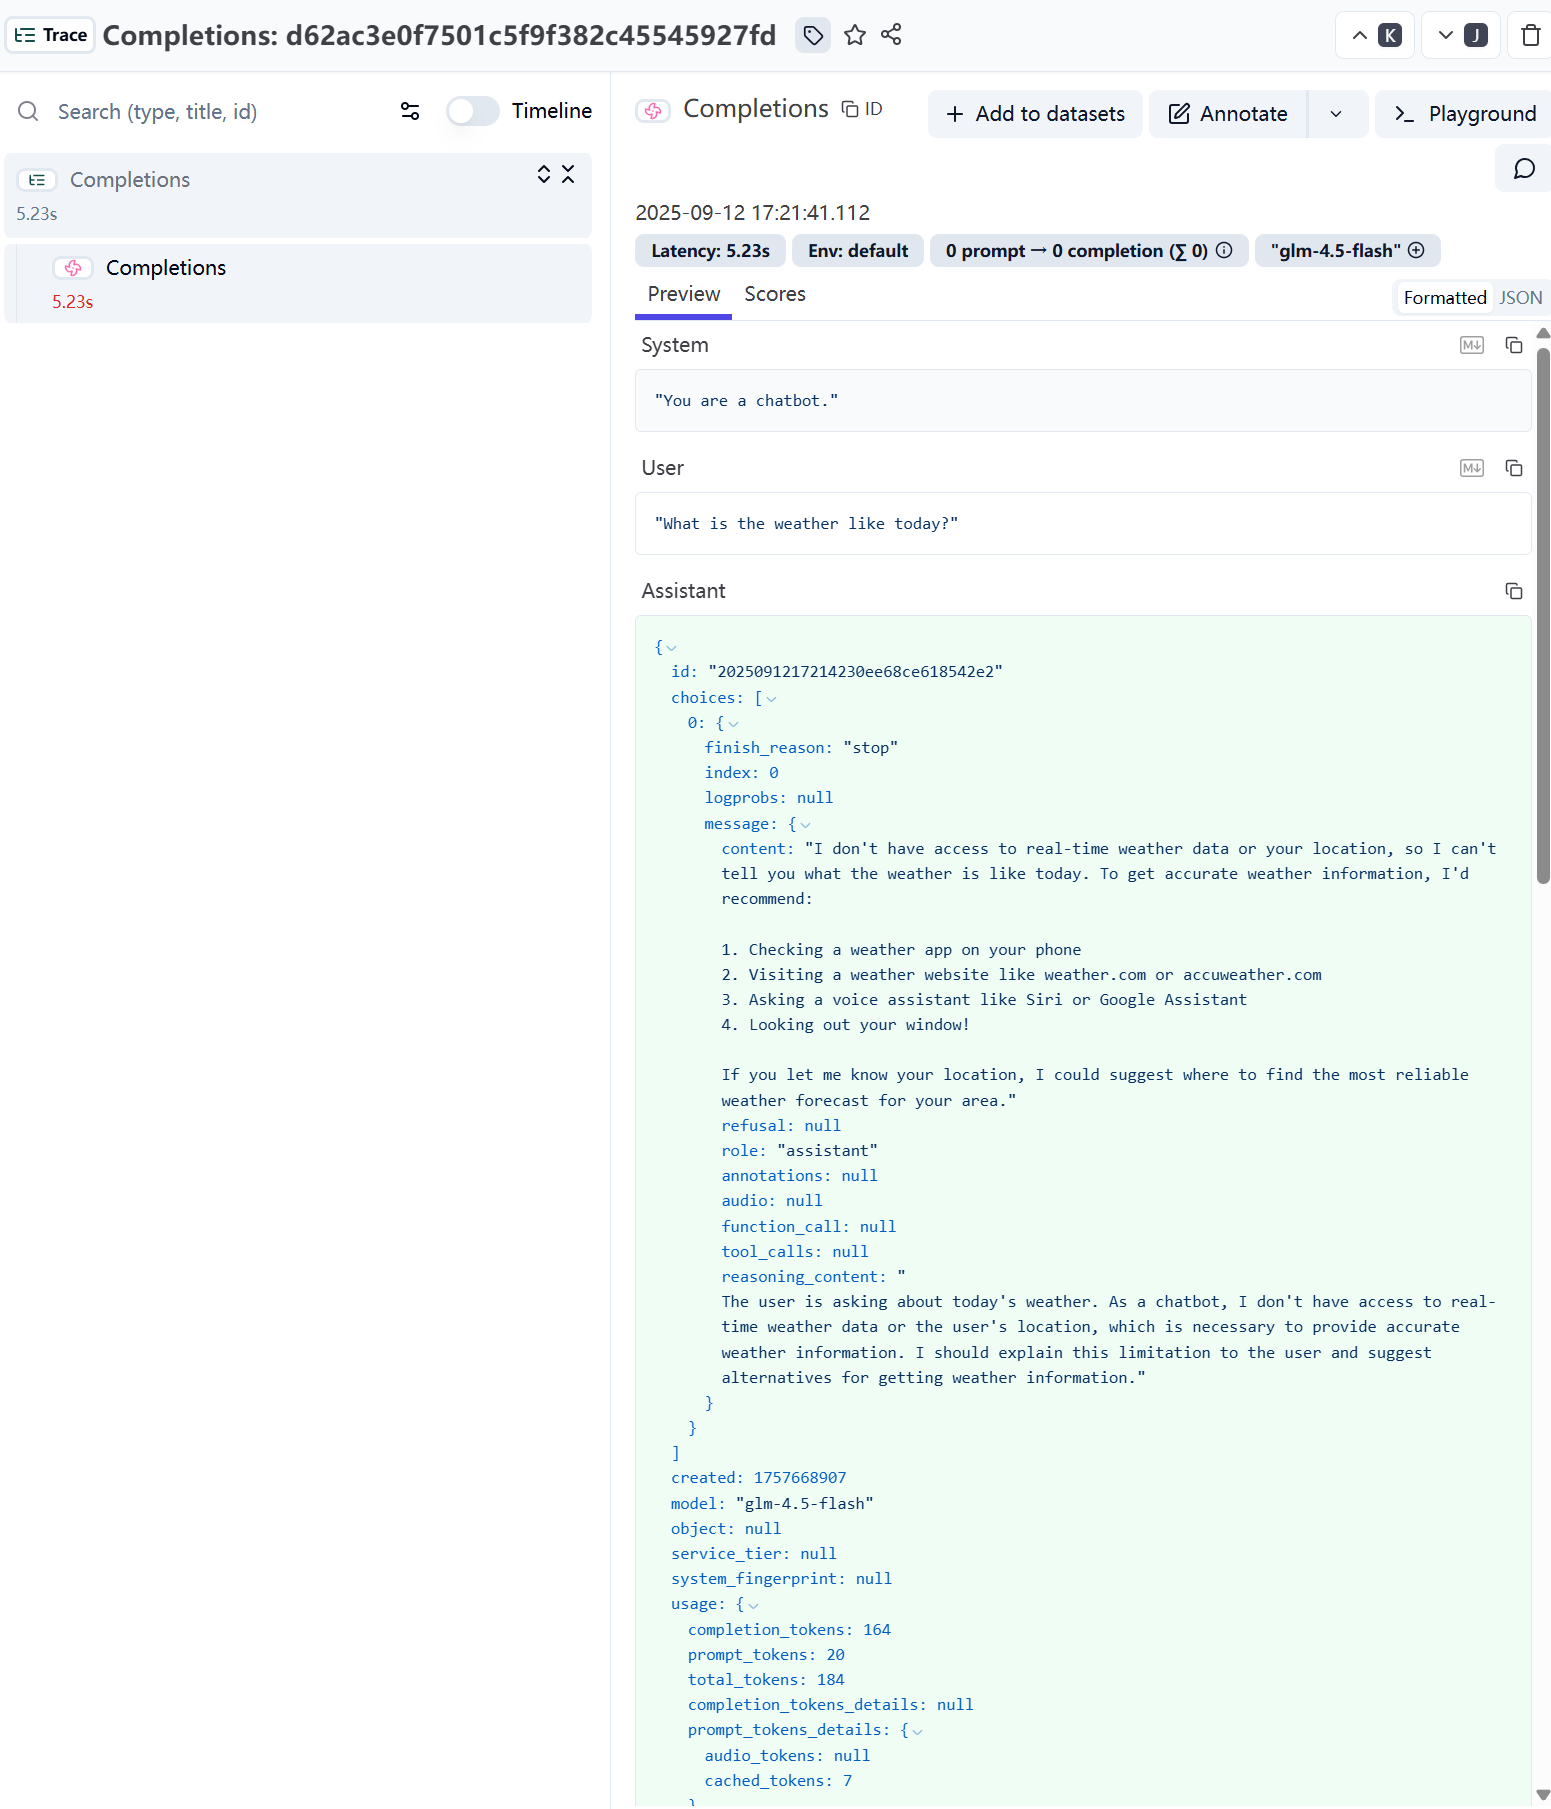

### Step 5: Pass Additional Attributes (Optional)

In [ ]:
import openai   

input = "How does enhanced LLM observability improve AI debugging?"

with tracer.start_as_current_span("OpenAI-Trace") as span:
    span.set_attribute("langfuse.user.id", "user-123")
    span.set_attribute("langfuse.session.id", "123456789")
    span.set_attribute("langfuse.tags", ["staging", "demo"])

    response = openai.OpenAI().chat.completions.create(
        model="glm-4.5-flash",
        messages=[
            {"role": "user", "content": input}
        ]
    )
    print(response.choices[0].message.content)
    span.set_attribute("input.value", input)
    span.set_attribute("output.value", response.choices[0].message.content)

Enhanced LLM observability significantly improves AI debugging by providing **deep, granular insights** into the model's inner workings and behavior, moving far beyond simple input/output logging. Here's how it transforms the debugging process:

1.  **Pinpointing Failure Points in the Generation Process:**
    *   **Beyond Black Box:** Traditional logging shows the prompt and the final response. Enhanced observability captures the *entire generation sequence*: token-by-token output, logits (probability distributions over the vocabulary), attention weights (which parts of the input/prompt the model is focusing on at each step), and hidden states.
    *   **Identifying the "Why":** When an output is incorrect or nonsensical, observability allows you to trace *exactly where* the generation went wrong. Did the model misinterpret a specific part of the prompt (revealed by attention)? Did it generate a token with low confidence (revealed by logits)? Did it get stuck in a loop? This granular 

: 

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/d01e65e0f82e924e3313cba277d0ab24?timestamp=2025-09-12T09%3A25%3A56.408Z&display=details&view=preview&observation=48edd2344852f7d0)

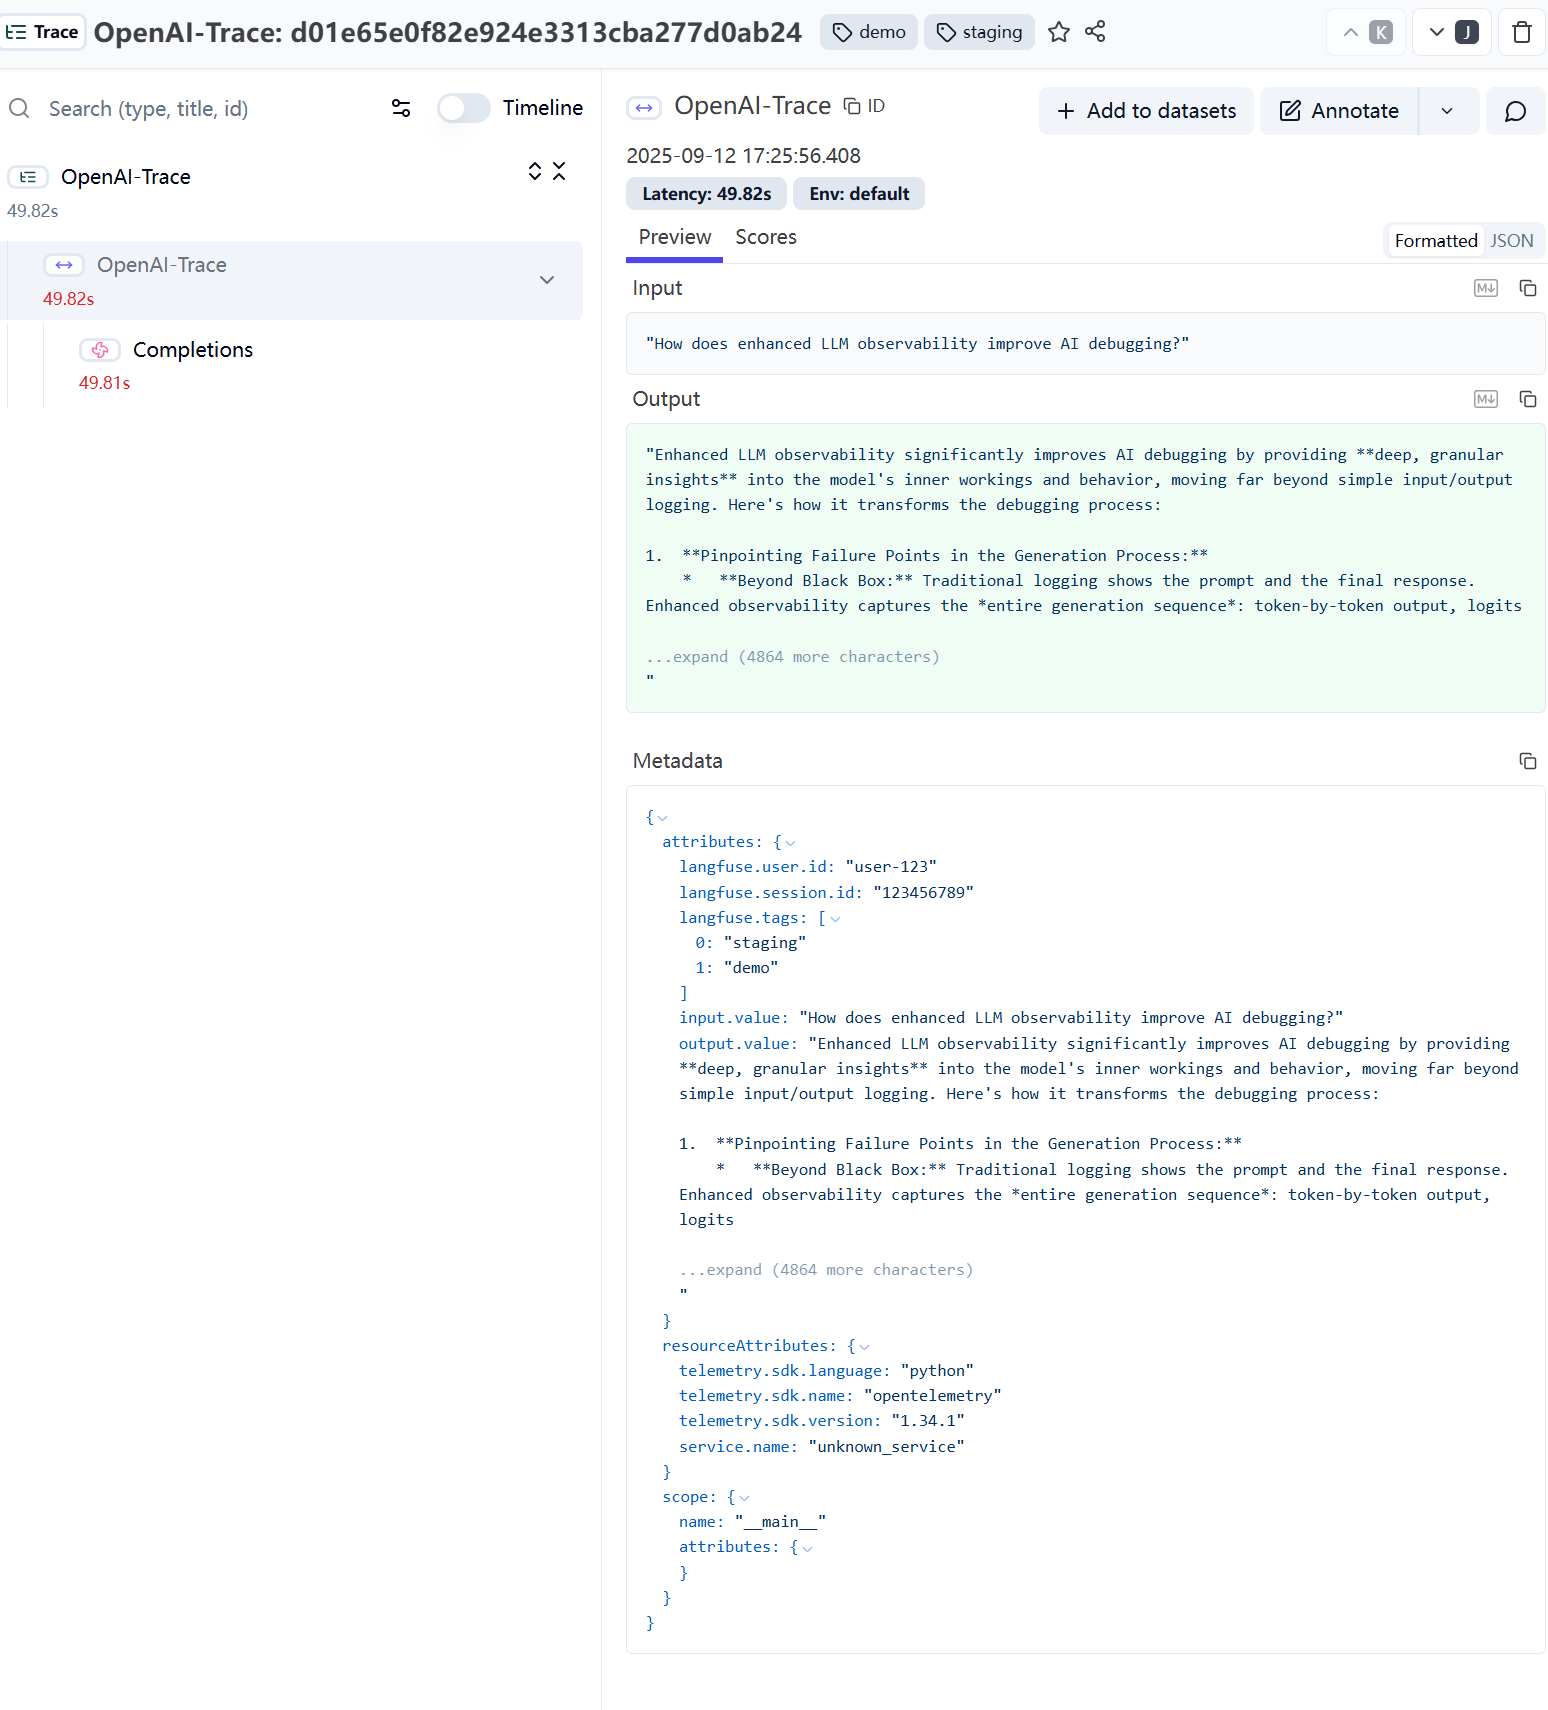